# 🧪 Taller - Análisis de Figuras Geométricas: Centroide, Área y Perímetro

## 🔍 Objetivo del taller

Detectar formas simples (círculos, cuadrados, triángulos) en imágenes binarizadas y calcular propiedades geométricas como área, perímetro y centroide. El objetivo es desarrollar habilidades para extraer métricas relevantes de contornos detectados en imágenes procesadas.

## 🔹 Actividades por entorno

Este taller se desarrolla en Python usando OpenCV.

## 💻 Python (Colab o Jupyter Notebook)

Herramientas: `opencv-python`, `numpy`, `matplotlib`

### ✅ 1. Importar Bibliotecas

Primero, importamos las bibliotecas necesarias: OpenCV (`cv2`), NumPy (`numpy`) para manejo de arrays y Matplotlib (`matplotlib.pyplot`) para visualización.

In [1]:
# 📦 Importar librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt


### ✅ 2. Cargar o Generar una Imagen Binarizada

Para este taller, generaremos una imagen sintética con algunas formas básicas (triángulo, cuadrado, círculo) y la binarizaremos. Si tienes una imagen binarizada de un taller anterior, puedes cargarla aquí.

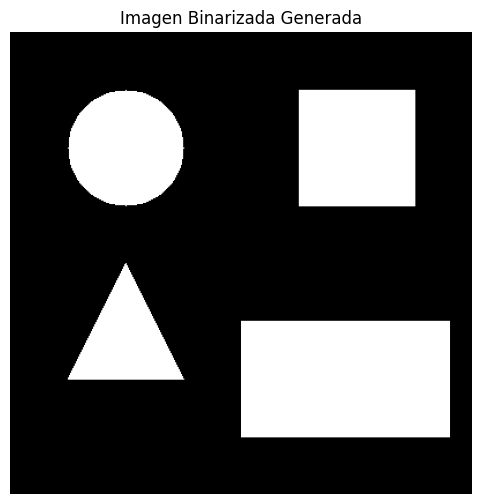

In [2]:
# Dimensiones de la imagen
width, height = 400, 400

# Crear una imagen en blanco (fondo negro)
image = np.zeros((height, width), dtype=np.uint8)

# Dibujar algunas formas en blanco (valor 255)
# Círculo
cv2.circle(image, (100, 100), 50, 255, -1) # Centro (100, 100), radio 50, color 255, relleno (-1)

# Cuadrado
cv2.rectangle(image, (250, 50), (350, 150), 255, -1) # Esquina superior izquierda (250, 50), esquina inferior derecha (350, 150), color 255, relleno (-1)

# Triángulo (usando contornos)
triangle_pts = np.array([[50, 300], [150, 300], [100, 200]], np.int32)
cv2.drawContours(image, [triangle_pts], 0, 255, -1) # Dibujar el contorno del triángulo, -1 para rellenar

# Un rectángulo más
cv2.rectangle(image, (200, 250), (380, 350), 255, -1)


# Mostrar la imagen binarizada generada
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title("Imagen Binarizada Generada")
plt.axis('off')
plt.show()

# Aunque ya la creamos con 0s y 255s, un threshold asegura que sea estrictamente binaria
# _, binary_image = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY) # No necesario si la creamos con 0 y 255

binary_image = image # Usamos la imagen directamente ya que está en 0 y 255


### ✅ 3. Detectar Contornos

Usamos `cv2.findContours()` para encontrar los contornos de las formas en la imagen binarizada.

* `cv2.RETR_EXTERNAL`: Recupera solo los contornos externos.
* `cv2.CHAIN_APPROX_SIMPLE`: Comprime segmentos horizontales, verticales y diagonales, dejando solo sus puntos finales.

In [3]:
# Encontrar contornos
# La función findContours puede devolver 2 o 3 valores dependiendo de la versión de OpenCV
# Usamos _ para ignorar el segundo valor (jerarquía)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Se encontraron {len(contours)} contornos.")


Se encontraron 4 contornos.


### ✅ 4. Calcular Propiedades y Etiquetar Figuras

Iteraremos sobre cada contorno detectado para calcular su área, perímetro y centroide. Luego, dibujaremos el contorno y mostraremos las métricas sobre una copia de la imagen original.

Además, agregaremos el bonus de clasificar la figura usando `cv2.approxPolyDP()` para aproximar el número de vértices.

In [4]:
# Crear una copia de la imagen para dibujar sobre ella (convertir a color para dibujar con colores)
output_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# Iterar sobre cada contorno encontrado
for i, contour in enumerate(contours):
    # Calcular Área
    area = cv2.contourArea(contour)

    # Omitir contornos muy pequeños que podrían ser ruido
    if area < 100:
        continue

    # Calcular Perímetro
    perimeter = cv2.arcLength(contour, True) # True indica que el contorno está cerrado

    # Calcular Momentos para el Centroide
    M = cv2.moments(contour)

    # Calcular Centroide (cx, cy)
    cX = 0
    cY = 0
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        # Si el área es cero, el centroide no está definido o el contorno es un punto/línea
        # En este caso, usamos el centro del bounding box como fallback (opcional)
        x, y, w, h = cv2.boundingRect(contour)
        cX = x + w // 2
        cY = y + h // 2


    # --- Bonus: Clasificación de la figura ---
    shape_type = "Desconocido"
    # Ajustar epsilon basado en el perímetro. 0.04 es un valor común.
    epsilon = 0.04 * perimeter
    approx = cv2.approxPolyDP(contour, epsilon, True) # Aproximación poligonal
    num_vertices = len(approx)

    if num_vertices == 3:
        shape_type = "Triangulo"
    elif num_vertices == 4:
         # Para un cuadrado, podríamos chequear la relación de aspecto del bounding box
         # o la igualdad de los lados aproximados, pero solo el conteo es una aproximación básica
         x, y, w, h = cv2.boundingRect(approx)
         aspect_ratio = float(w)/h
         # Permitimos una pequeña tolerancia para cuadrados
         if aspect_ratio >= 0.85 and aspect_ratio <= 1.15: # Tolerancia ajustada
             shape_type = "Cuadrado"
         else:
              shape_type = "Rectangulo"
    elif num_vertices > 4 and num_vertices < 12: # Un polígono con más de 4 pero pocos vértices
         shape_type = f"Poligono({num_vertices})"
    else: # Un número grande de vértices puede indicar un círculo o forma irregular
         # Una heurística para círculos: tienen muchos vértices en la aproximación
         # y su área es cercana al área de su bounding circle o tienen alta solidez
         (x, y), radius = cv2.minEnclosingCircle(contour)
         circle_area = np.pi * (radius ** 2)
         # Comparar área del contorno con el área del círculo envolvente (con tolerancia)
         if area > 100 and circle_area > 0 and (area / circle_area) > 0.8: # Si el área es al menos el 80% del círculo envolvente
              shape_type = "Circulo"
         else:
              shape_type = "Forma Irregular"


    # --- Dibujar y Etiquetar ---

    # Dibujar el contorno (con un color aleatorio para distinguirlos)
    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    cv2.drawContours(output_image, [contour], -1, color, 2) # -1 para dibujar todos los puntos del contorno

    # Preparar el texto con las métricas y la clasificación
    text_shape = f"Forma: {shape_type}"
    text_area = f"Area: {area:.2f}"
    text_perimeter = f"Perim: {perimeter:.2f}"
    text_centroid = f"Centroide: ({cX}, {cY})"


    # Posicionar el texto cerca del centroide
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.4
    font_thickness = 1
    line_spacing = 15 # Espacio vertical entre líneas de texto

    # Dibujar el centroide como un punto
    cv2.circle(output_image, (cX, cY), 3, (0, 0, 255), -1) # Rojo

    # Coordenada inicial para el texto (ligeramente encima del centroide)
    text_y_start = cY - 40
    text_x_start = cX - 40 # Ajustar posición X para centrar/alinear mejor

    # Dibujar las líneas de texto (verificar que no se salgan de la imagen si es necesario)
    if text_y_start < 10:
        text_y_start = cY + 20 # If too high, draw below centroid

    # Ensure text_x_start is not negative
    if text_x_start < 0:
        text_x_start = 5 # Small padding from left edge

    cv2.putText(output_image, text_shape, (text_x_start, text_y_start), font, font_scale, color, font_thickness)
    cv2.putText(output_image, text_area, (text_x_start, text_y_start + line_spacing), font, font_scale, color, font_thickness)
    cv2.putText(output_image, text_perimeter, (text_x_start, text_y_start + 2 * line_spacing), font, font_scale, color, font_thickness)
    cv2.putText(output_image, text_centroid, (text_x_start, text_y_start + 3 * line_spacing), font, font_scale, color, font_thickness)


### ✅ 5. Mostrar el Resultado

Finalmente, mostramos la imagen con los contornos dibujados y las métricas etiquetadas.

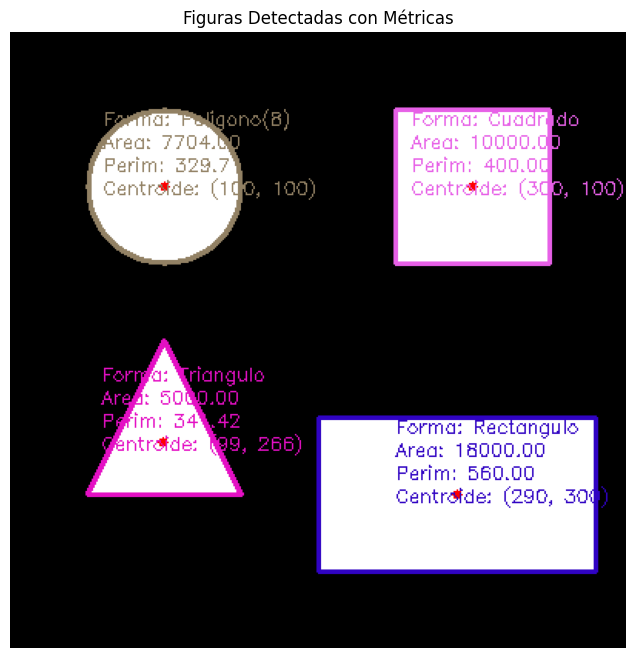

In [5]:
# Mostrar la imagen resultante con los contornos y etiquetas
plt.figure(figsize=(8, 8))
# Matplotlib espera imágenes en RGB, OpenCV usa BGR, así que convertimos si la imagen es a color
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Figuras Detectadas con Métricas")
plt.axis('off')
plt.show()
